In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import differential_evolution as de

import sys
sys.path.append("../models/")
import gr4j

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
meteo = pd.read_pickle("../data/meteo_kwbs.pkl")

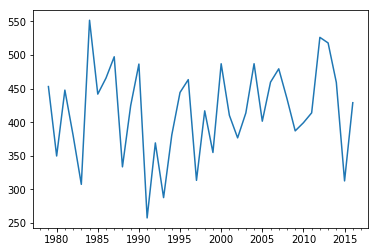

In [3]:
meteo["Prec"].resample("A").sum().plot()

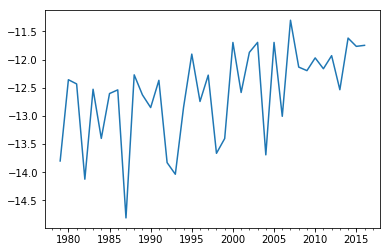

In [4]:
meteo["Temp"].resample("A").mean().plot()

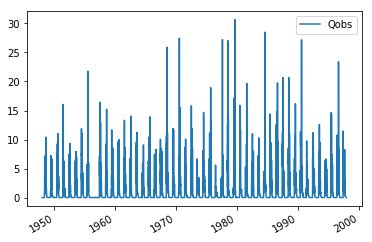

In [7]:
runoff= pd.read_pickle("../data/runoff_kwbs.pkl")

area = 21.43
coef = (86400*1000)/(area*1000000)

runoff = pd.DataFrame(runoff * coef)
runoff.columns = ["Qobs"]

runoff.plot()

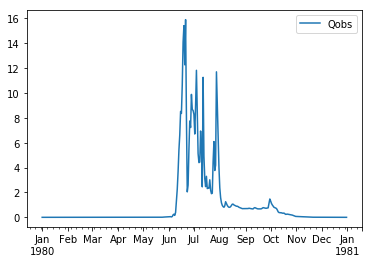

In [8]:
runoff["1980"].plot()

In [9]:
periods = {"first"  : ["1980-01-01", "1988-12-31"], 
           "second" : ["1989-01-01", "1997-12-31"], 
           "full"   : ["1980-01-01", "1997-12-31"]}

In [10]:
def NS(obs, sim):
    
    numerator = np.nansum( (obs - sim)**2 )
    
    denominator = np.nansum( (obs - np.nanmean(obs))**2 )
    
    return 1 - numerator / denominator

In [11]:
def model_calibration(period_name, period_instance):
    
    # use meteo data
    _meteo = meteo[                   : period_instance[1]]
    
    # runoff data as a target
    Qobs   = runoff[period_instance[0]: period_instance[1]]
    
    # Define an objective function we want to minimize
    
    def objective_function(params):
        
        # calculate runoff with updated parameters
        Qsim = pd.DataFrame({"Qsim": gr4j.simulation(_meteo, params)}, index = _meteo.index)
        
        # Wrap-up simulated runoff with the observed one
        # Drop all missing values for consistency
        Q_df = pd.concat([Qsim, Qobs], axis=1).dropna()
        
        # Calculate objective function value
        # 1 - NS
        return 1 - NS(Q_df["Qobs"].values, Q_df["Qsim"].values)
    
    # The core of calibration algorithm
    ## Specify objective function
    ## Specify parameters' boundaries within lookup is running
    ## Specify parameters of the algorithm
    ### maxiter - iterations of calibration algorithm run
    ### polish  - local search of the best solution
    ### disp    - displaying progress
    ### seed    - random number seed for reproducibility
    
    result = de(objective_function, gr4j.bounds(), maxiter=5, polish=True, disp=True, seed=142)
    
    # return optimal parameters we search
    
    return result.x

# Create a holder for optimal model parameters

opt_pars = {}

# Run calibration routine for every period we have defined

for period_name, period_instance in periods.items():
    
    print(period_name)
    
    opt_pars[period_name] = model_calibration(period_name, period_instance)
    
print("Done!")

opt_pars

first
differential_evolution step 1: f(x)= 0.60252
differential_evolution step 2: f(x)= 0.572208
differential_evolution step 3: f(x)= 0.572208
differential_evolution step 4: f(x)= 0.553937
differential_evolution step 5: f(x)= 0.553937
second
differential_evolution step 1: f(x)= 0.63211
differential_evolution step 2: f(x)= 0.621371
differential_evolution step 3: f(x)= 0.609271
differential_evolution step 4: f(x)= 0.597541
differential_evolution step 5: f(x)= 0.597541


../models/gr4j.py:123: RuntimeWarning: invalid value encountered in double_scalars
  WS = EN/X1
../models/gr4j.py:128: RuntimeWarning: invalid value encountered in double_scalars
  Sr = St[0]/X1
../models/gr4j.py:123: RuntimeWarning: divide by zero encountered in double_scalars
  WS = EN/X1
../models/gr4j.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  WS = PN/X1
../models/gr4j.py:216: RuntimeWarning: invalid value encountered in greater_equal
  Q = np.where(Q >= 0, Q, 0)


full
differential_evolution step 1: f(x)= 0.616966
differential_evolution step 2: f(x)= 0.602409
differential_evolution step 3: f(x)= 0.574673
differential_evolution step 4: f(x)= 0.574673
differential_evolution step 5: f(x)= 0.574673
Done!


{'first': array([ 77.04283298,   4.82419308, 271.42400461,   2.0736991 ,
          0.44756573,   3.8426119 ]),
 'full': array([1.23543416e-08, 2.73848653e+00, 3.76157323e+02, 3.74100468e+00,
        1.13491193e-01, 3.54999860e+00]),
 'second': array([7.10219039e-02, 2.60691275e+00, 3.47755438e+02, 4.00000000e+00,
        5.75384207e-01, 2.75229017e+00])}

In [32]:
# Calculate a simulated runoff and place it in the one pandas DataFrame
qsim = pd.concat([pd.DataFrame({"Qsim_{}".format(period) : gr4j.simulation(meteo, opt_pars[period])}, index = meteo.index) for period in opt_pars.keys()], axis=1)

In [33]:
# Create a helper pandas DataFrame for holding all the data together
qdf = pd.concat([qsim, runoff], axis=1)

In [34]:
# Calculate a calibration/validation matrix

## Create a holder
validation_array = np.zeros((3, 3))

## Calibration periods in rows
for i, period_name in enumerate(periods.keys()):
    
    ## Validation periods in columns
    for j, period_instance in enumerate(periods.values()):
        
        Qo = runoff[period_instance[0]: period_instance[1]]
        
        Qs = qdf["Qsim_"+period_name][period_instance[0]: period_instance[1]]
        
        Q_df = pd.concat([Qs, Qo], axis=1).dropna()
        
        validation_array[i, j] = NS(Q_df["Qobs"].values, Q_df["Qsim_"+period_name].values)
        

# Convert to a pandas DataFrame for a nice look
validation_table = pd.DataFrame(validation_array, columns=periods.keys(), index=periods.keys())

# Plot the results
validation_table

,first,second,full
first,0.449881,0.388951,0.424744
second,0.425808,0.428399,0.427041
full,0.447495,0.420075,0.436267


In [35]:
# Read in HYDROGRAPH model results
qsim_hype = pd.read_table("../data/runoff_kwbs_hype.txt", skiprows=2, header=None, index_col=0, parse_dates=True, names=["HYPE", "Qobs"])["HYPE"]
qsim_hype = pd.DataFrame(qsim_hype)
qsim_hype.head()

,HYPE
1980-01-01,0.0
1980-01-02,0.0
1980-01-03,0.0
1980-01-04,0.0
1980-01-05,0.0


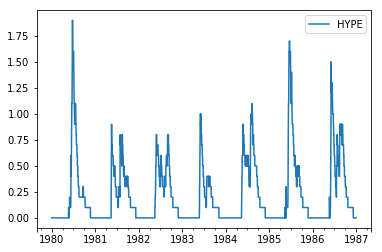

In [36]:
qsim_hype.plot()

In [37]:
# Convert the baseline solution back to m3/s and concatenate with HYdrograph model results
qdf = pd.concat([qdf / coef, qsim_hype], axis=1)

qdf = qdf.dropna()

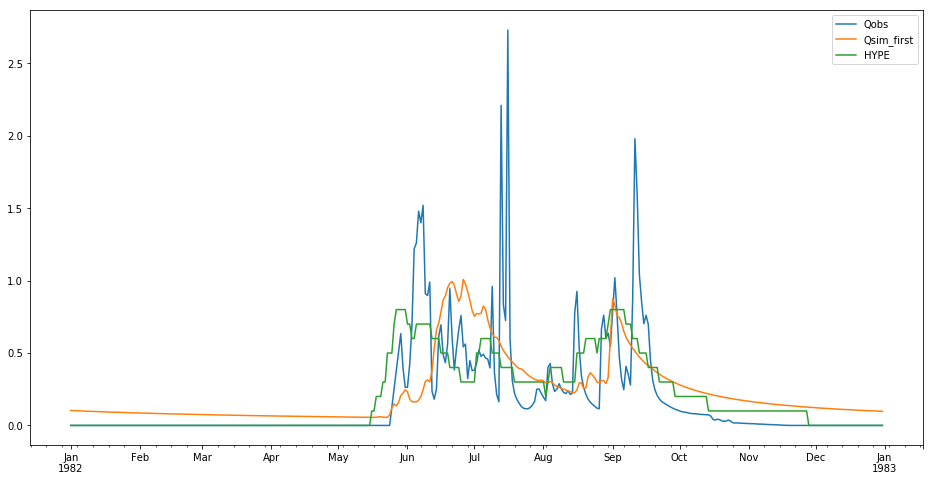

In [39]:
qdf[["Qobs", "Qsim_first", "HYPE"]]["1982"].plot(figsize=(16,8))

In [40]:
# Year-wise NS BASELINE
baseline_NS = [NS(qdf["Qobs"][str(year)], qdf["Qsim_full"][str(year)]) for year in range(1980, 1986)]

#hydrograph_NS = [NS(qdf["Qobs"][str(year)], qdf["Hydrograph"][str(year)]) for year in range(1980, 1986)]

hype_NS = [NS(qdf["Qobs"][str(year)], qdf["HYPE"][str(year)]) for year in range(1980, 1986)]

In [41]:
print("Baseline, full period NS:", NS(qdf["Qobs"]["1980":"1985"], qdf["Qsim_full"]["1980":"1985"]))
#print("Hydrograph, full period NS:", NS(qdf["Qobs"]["1980":"1985"], qdf["Hydrograph"]["1980":"1985"]))
print("HYPE, full period NS:", NS(qdf["Qobs"]["1980":"1985"], qdf["HYPE"]["1980":"1985"]))

Baseline, full period NS: 0.48167260189274597
HYPE, full period NS: 0.5447828996920836


Text(0,0.5,'NS')

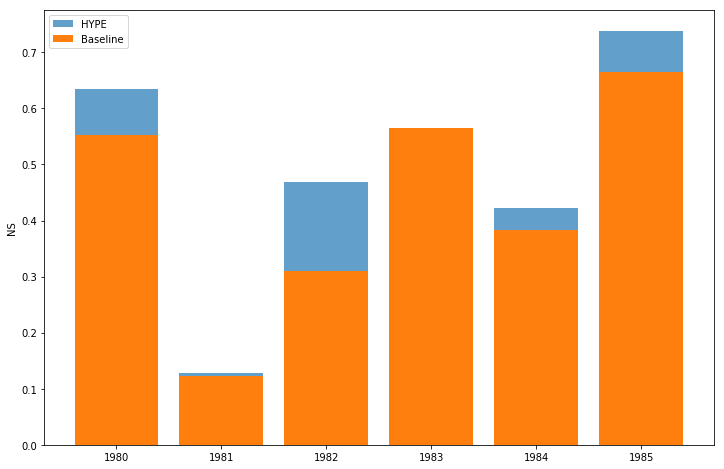

In [42]:
plt.figure(figsize=(12, 8))
#plt.bar([i for i in range(1980, 1986)], hydrograph_NS, alpha=0.85, label="HYDROGRAPH")
plt.bar([i for i in range(1980, 1986)], hype_NS, alpha=0.7, label="HYPE")
plt.bar([i for i in range(1980, 1986)], baseline_NS, label="Baseline")
plt.legend()
plt.ylabel("NS")

$$ NSE = 1-\frac{\sum_{i=1}^{N}(obs_{i}-sim_{i})^2}{\sum_{i=1}^{N}(obs_{i}-\bar{obs})^2} $$

_______________

$$ NSE_{gain} = 1-\frac{\sum_{i=1}^{N}(obs_{i}-sim_{i})^2}{\sum_{i=1}^{N}(obs_{i}-baseline_{i})^2} $$

In [43]:
def NS_gain(obs, sim, baseline):
    
    numerator = np.nansum( (obs - sim)**2 )
    
    denominator = np.nansum( (obs - baseline)**2 )
    
    return 1 - numerator / denominator

In [45]:
#hydrograph_gain_NS = [NS_gain(qdf["Qobs"][str(year)], qdf["Hydrograph"][str(year)], qdf["Qsim_full"][str(year)]) for year in range(1980, 1986)]
hype_gain_NS = [NS_gain(qdf["Qobs"][str(year)], qdf["HYPE"][str(year)], qdf["Qsim_full"][str(year)]) for year in range(1980, 1986)]

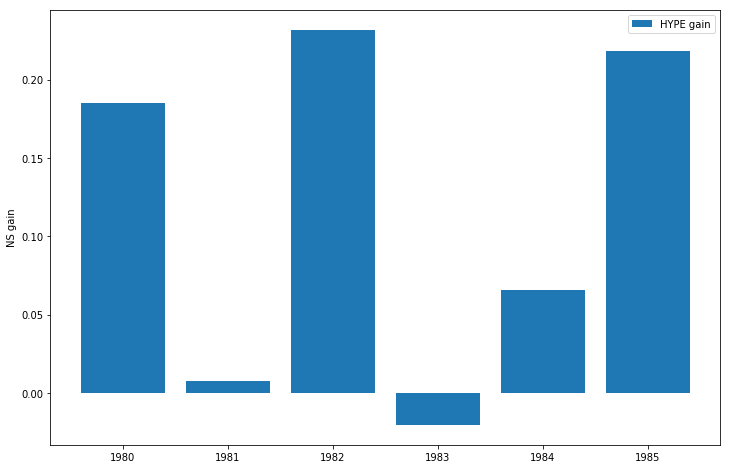

In [46]:
plt.figure(figsize=(12, 8))
#plt.bar([i for i in range(1980, 1986)], hydrograph_gain_NS, label="Hydrograph gain")
plt.bar([i for i in range(1980, 1986)], hype_gain_NS, label="HYPE gain")
plt.ylabel("NS gain")
plt.legend()